# Quantum Counting

Quantum Counting is an algorithm which brings together the Grover's Algorithm and the Shor's Algorithm. It estimates the phase while giving us an approximate



# Dependencies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
!pip install qiskit
import qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer

# import basic plot tools
from qiskit.visualization import plot_histogram
!pip install pylatexenc
import pylatexenc

  Using cached qiskit-0.36.1.tar.gz (13 kB)
  Using cached qiskit_terra-0.20.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Using cached qiskit_aer-0.10.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (18.0 MB)
  Using cached qiskit_ibmq_provider-0.19.1-py3-none-any.whl (240 kB)
  Using cached qiskit_ignis-0.7.0-py3-none-any.whl (200 kB)
  Using cached websocket_client-1.3.2-py3-none-any.whl (54 kB)
  Using cached requests_ntlm-1.1.0-py2.py3-none-any.whl (5.7 kB)
  Using cached websockets-10.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (112 kB)
  Using cached retworkx-0.11.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached tweedledum-1.1.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (943 kB)
     |████████████████████████████████| 37.5 MB 52.5 MB/s 
  Using cached stevedore-3.5.0-py3-none-any.whl (49 kB)
  Using 

We choose to ‘count’ on the first 4 qubits on our circuit ($t = 4$) to 'search' through the last 4 qubits ($n = 4$).

# Controlled Grover Iterator <a id='cont_grover'></a>

 Here is an example with an Oracle we know has 5 solutions ($M = 5$) of 16 states ($N = 2^n = 16$), combined with a diffusion operator:

In [ ]:
def grover_iterator():
    """Small circuit with 5/16 solutions"""
    # Do circuit
    qc = QuantumCircuit(4)
    # Oraclee
    qc.x(2)
    qc.ccx(0,2,3)
    qc.x(2)
    qc.h(3)
    qc.x([1,3])
    qc.h(2)
    qc.mct([0,1,3],2)
    qc.x([1,3])
    qc.h(2)
    # Diffuser
    qc.h(range(3))
    qc.x(range(3))
    qc.z(3)
    qc.mct([0,1,2],3)
    qc.x(range(3))
    qc.h(range(3))
    qc.z(3)
    return qc

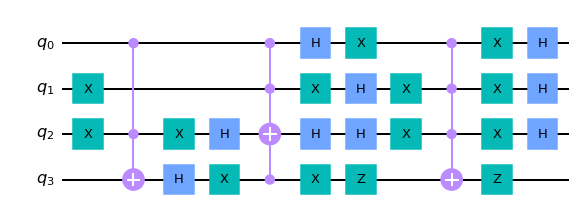

In [ ]:
grover_iterator().draw('mpl')

Notice the python function takes no input and returns a `QuantumCircuit` object with 4 qubits. In the past the functions you created might have modified an existing circuit, but a function like this allows us to turn the `QuantumCircuit` object into a single gate we can then control.

We can use `.to_gate()` and `.control()` to create a controlled gate from a circuit. We will call our Grover iterator `grit` and the controlled Grover iterator `cgrit`:

In [ ]:
# Create controlled-Grover
grit = grover_iterator().to_gate()
grit.label = "Grover"
cgrit = grit.control()

# Inverse QFT
We now need to create an inverse QFT. This code implements the QFT on n qubits:

In [ ]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)

    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

Again, note we have chosen to return another `QuantumCircuit` object, this is so we can easily invert the gate. We create the gate with t = 4 qubits as this is the number of counting qubits we have chosen in this guide:

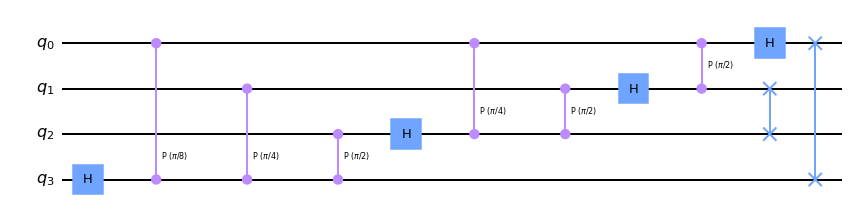

In [ ]:
qft(4).draw('mpl')

In [ ]:
qft_dagger = qft(4).to_gate().inverse()
qft_dagger.label = "QFT†"

# Putting it Together

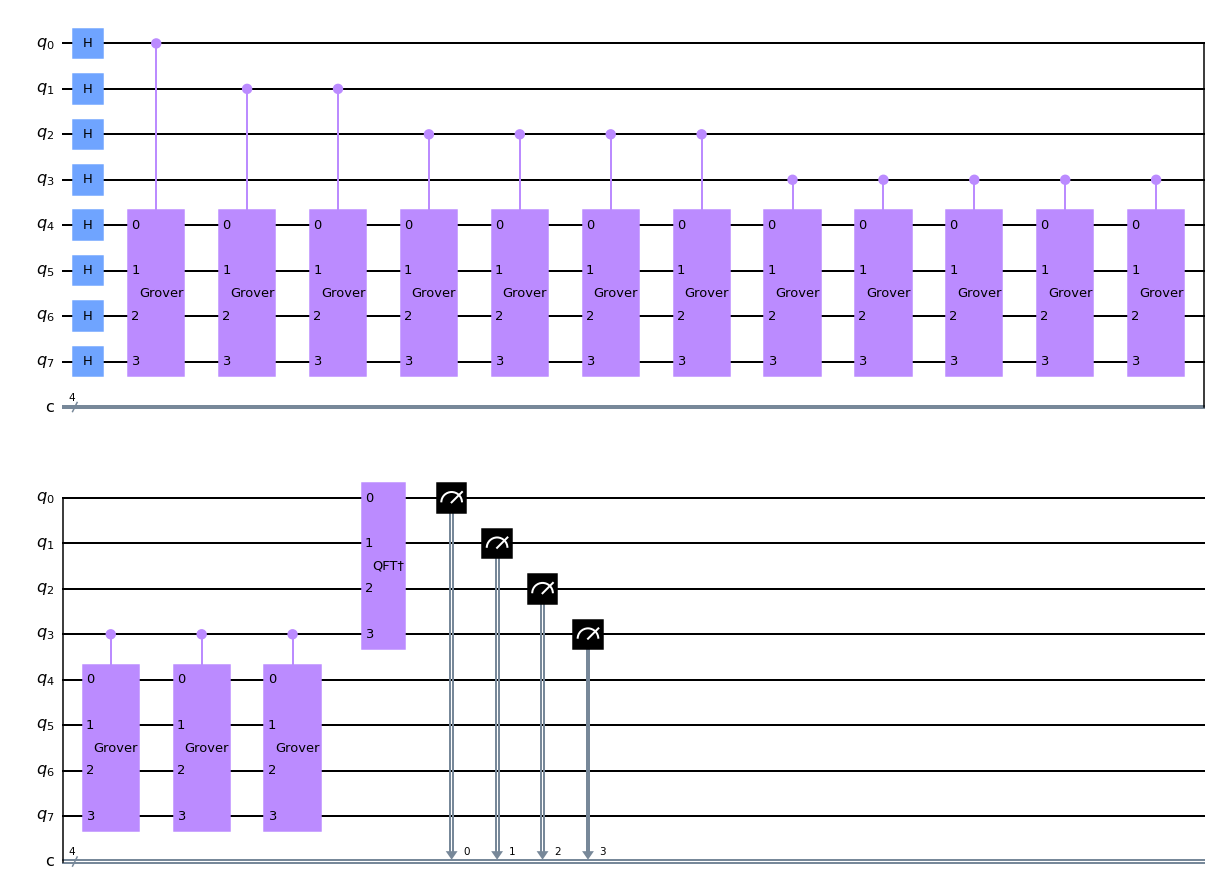

In [ ]:
# Create QuantumCircuit
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2

# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw('mpl')

Great! Now let’s see some results.

# Simulation


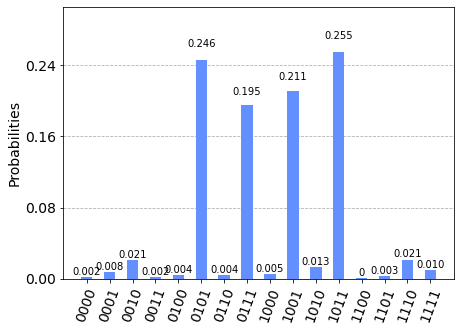

In [ ]:
# Execute and see results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

In [ ]:
hist

{'0000': 2,
 '0001': 8,
 '0010': 21,
 '0011': 2,
 '0100': 4,
 '0101': 252,
 '0110': 4,
 '0111': 200,
 '1000': 5,
 '1001': 216,
 '1010': 13,
 '1011': 261,
 '1100': 1,
 '1101': 3,
 '1110': 22,
 '1111': 10}

In [ ]:
measured_str = max(hist, key=hist.get)
measured_str

'1011'

Let us now store this as an integer:

In [ ]:
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 11


# Finding the Number of Solutions (M)


In [ ]:
def calculate_M(measured_int, t, n):
    """For Processing Output of Quantum Counting"""
    # Calculate Theta
    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)
    # Calculate No. of Solutions
    N = 2**n
    M = N * (math.sin(theta/2)**2)
    print("No. of Solutions = %.1f" % (N-M))
    # Calculate Upper Error Bound
    m = t - 1 #Will be less than this (out of scope)
    err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
    print("Error < %.2f" % err)

In [ ]:
calculate_M(measured_int, t, n)

Theta = 4.31969
No. of Solutions = 4.9
Error < 2.48


# For t = 2

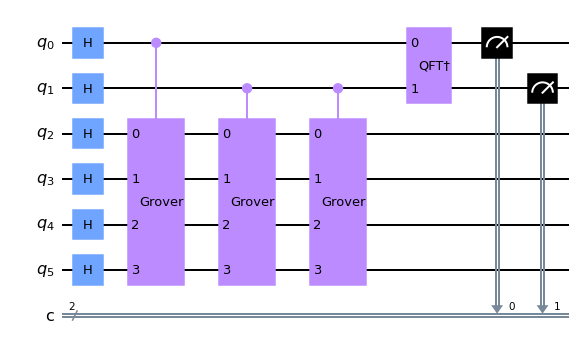

In [ ]:
# Create QuantumCircuit
t = 2   # no. of counting qubits
n = 4   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2

# Do inverse QFT on counting qubits
qft_dagger = qft(t).to_gate().inverse()
qft_dagger.label = "QFT†"
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw('mpl')

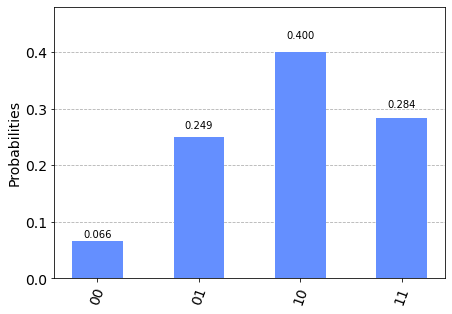

In [ ]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

In [ ]:
hist

{'00': 68, '01': 255, '10': 410, '11': 291}

In [ ]:
measured_str = max(hist, key=hist.get)
measured_str

'10'

In [ ]:
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 2


In [ ]:
calculate_M(measured_int, t, n)

Theta = 3.14159
No. of Solutions = 0.0
Error < 13.31


# For t = 8


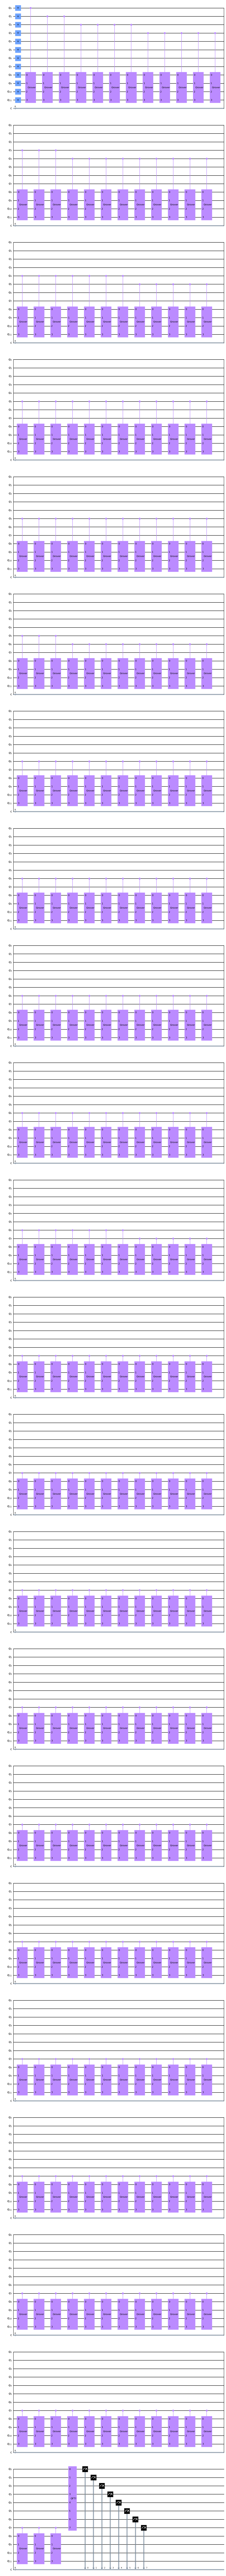

In [ ]:
# Create QuantumCircuit
t = 8   # no. of counting qubits
n = 4   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2

# Do inverse QFT on counting qubits
qft_dagger = qft(t).to_gate().inverse()
qft_dagger.label = "QFT†"
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw('mpl')

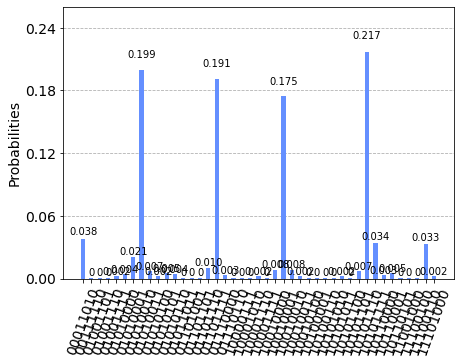

In [ ]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

In [ ]:
hist

{'00011010': 39,
 '00111110': 1,
 '01001101': 1,
 '01001110': 1,
 '01001111': 2,
 '01010000': 4,
 '01010001': 21,
 '01010010': 204,
 '01010011': 7,
 '01010100': 2,
 '01010101': 5,
 '01010110': 4,
 '01011011': 1,
 '01101001': 1,
 '01101101': 1,
 '01101110': 10,
 '01101111': 196,
 '01110000': 3,
 '01110110': 1,
 '10000111': 1,
 '10001010': 1,
 '10001110': 2,
 '10001111': 1,
 '10010000': 8,
 '10010001': 179,
 '10010010': 8,
 '10010011': 2,
 '10010100': 1,
 '10100001': 1,
 '10100110': 1,
 '10101010': 1,
 '10101011': 2,
 '10101100': 1,
 '10101101': 7,
 '10101110': 222,
 '10101111': 35,
 '10110000': 3,
 '10110001': 5,
 '10110101': 1,
 '11001000': 1,
 '11100100': 1,
 '11100110': 34,
 '11101000': 2}

In [ ]:
measured_str = max(hist, key=hist.get)
measured_str

'10101110'

In [ ]:
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 174


In [ ]:
calculate_M(measured_int, t, n)

Theta = 4.27060
No. of Solutions = 4.6
Error < 0.15


# t vs error

In [ ]:
def calculate_M_mod(measured_int, t, n):
  """For Processing Output of Quantum Counting"""
  # Calculate Theta
  theta = (measured_int/(2**t))*math.pi*2
  # Calculate No. of Solutions
  N = 2**n
  M = N * (math.sin(theta/2)**2)
  # Calculate Upper Error Bound
  m = t - 1 #Will be less than this (out of scope)
  err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
  return err

In [ ]:
def simulate(t_n):
  # Create QuantumCircuit
  t = t_n   # no. of counting qubits
  n = 4   # no. of searching qubits
  qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

  # Initialize all qubits to |+>
  for qubit in range(t+n):
      qc.h(qubit)

  # Begin controlled Grover iterations
  iterations = 1
  for qubit in range(t):
      for i in range(iterations):
          qc.append(cgrit, [qubit] + [*range(t, n+t)])
      iterations *= 2

  # Do inverse QFT on counting qubits
  qft_dagger = qft(t).to_gate().inverse()
  qft_dagger.label = "QFT†"
  qc.append(qft_dagger, range(t))

  # Measure counting qubits
  qc.measure(range(t), range(t))

  # Display the circuit
  qc.draw('mpl')

  aer_sim = Aer.get_backend('aer_simulator')
  transpiled_qc = transpile(qc, aer_sim)
  qobj = assemble(transpiled_qc)
  job = aer_sim.run(qobj)
  hist = job.result().get_counts()
  plot_histogram(hist)

  measured_str = max(hist, key=hist.get)
  measured_int = int(measured_str,2)

  error = calculate_M_mod(measured_int, t, n)
  return error

In [ ]:
t_arr = [i for i in list((range(1,11)))]
err_arr = [0 for i in (range(1,11))]

for i in range(len(err_arr)):
  err_arr[i] = simulate(t_arr[i])
  print("Done for " + str(t_arr[i]))

Done for 1
Done for 2
Done for 3
Done for 4
Done for 5
Done for 6
Done for 7
Done for 8
Done for 9
Done for 10


In [ ]:
t_arr

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
err_arr

[30.627416997969522,
 13.313708498984761,
 5.726251859505506,
 2.476751204838718,
 1.207125602419359,
 0.7013324226610738,
 0.30065396754884954,
 0.14983870252442477,
 0.07450572422336536,
 0.03729540909082002]

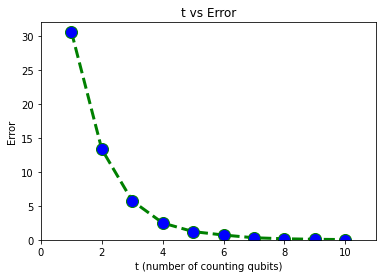

In [ ]:
# plotting the points
plt.plot(t_arr, err_arr, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)

# setting x and y axis range
plt.ylim(0,32)
plt.xlim(0,11)

# naming the x axis
plt.xlabel('t (number of counting qubits)')
# naming the y axis
plt.ylabel('Error')

# giving a title to my graph
plt.title('t vs Error')

# function to show the plot
plt.show()

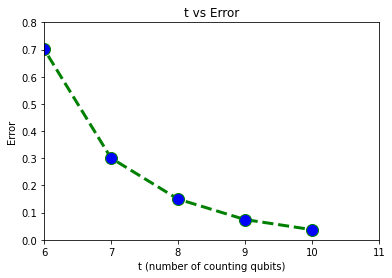

In [ ]:
# plotting the points
plt.plot(t_arr, err_arr, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)

# setting x and y axis range
plt.ylim(0,.8)
plt.xlim(6,11)

# naming the x axis
plt.xlabel('t (number of counting qubits)')
# naming the y axis
plt.ylabel('Error')

# giving a title to my graph
plt.title('t vs Error')

# function to show the plot
plt.show()